In [1]:
"""Make sure the reward functions work how I expect them to"""
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from influence_moo.env.env import Rewards, AUV, ASV, POI
from influence_moo.plotting import plot_grid, plot_pts

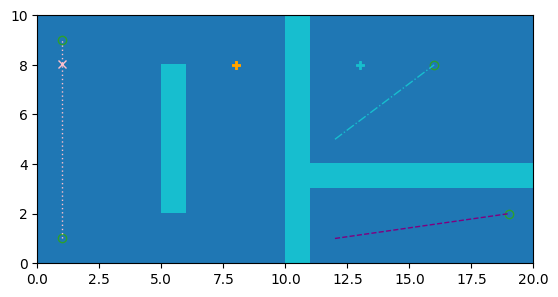

In [2]:
# Spoof a rollout
connectivity_grid = np.ones((20, 10))
connectivity_grid[10,:] = 0.0
connectivity_grid[5,2:8] = 0.0
connectivity_grid[10:,3] = 0.0

pois = [
    POI(position=np.array([1,9]), value=0.3, observation_radius=1.0),
    POI(position=np.array([1,1]), value=2.5, observation_radius=1.0),
    POI(position=np.array([16,8]), value=1.2, observation_radius = 1.0),
    POI(position=np.array([19,2]), value=3.7, observation_radius = 1.0)
]
poi_positions = np.array([poi.position for poi in pois])

auvs = [
    AUV(targets=[None], max_velocity=None),
    AUV(targets=[None], max_velocity=None),
    AUV(targets=[None], max_velocity=None)
]

# For tracking auvs during testing
for id, auv in enumerate(auvs):
    auv.id = id

auv0_xs = np.linspace(1.,1.,100)
auv0_ys = np.linspace(1.,9.,100)
auvs[0].path = np.array([auv0_xs, auv0_ys]).T

auv1_xs = np.linspace(12.,19.,100)
auv1_ys = np.linspace(1.,2.,100)
auvs[1].path = np.array([auv1_xs, auv1_ys]).T

auv2_xs = np.linspace(12.,16.,100)
auv2_ys = np.linspace(5.,8.,100)
auvs[2].path = np.array([auv2_xs, auv2_ys]).T

asvs = [
    ASV(position=None, auvs=auvs, connectivity_grid=None, policy_function=None),
    ASV(position=None, auvs=auvs, connectivity_grid=None, policy_function=None)
]

# For tracking these asvs during testing
for id, asv in enumerate(asvs):
    asv.id = id

asv0_xs = np.linspace(8.,8.,100)
asv0_ys = np.linspace(8.,8.,100)
asvs[0].path = np.array([asv0_xs, asv0_ys]).T

asv1_xs = np.linspace(13,13,100)
asv1_ys = np.linspace(8,8,100)
asvs[1].path = np.array([asv1_xs, asv1_ys]).T

fig, ax = plt.subplots(1,1,dpi=100)
plot_grid(connectivity_grid, cmap='tab10_r')
plot_pts(poi_positions, ax, marker='o', fillstyle='none', linestyle='none',color='tab:green')
plot_pts(auvs[0].path, ax, ls=(0, (1,2)), color='pink', lw=1)
plot_pts(auvs[1].path, ax, ls='dashed', color='purple', lw=1)
plot_pts(auvs[2].path, ax, ls='dashdot', color='tab:cyan', lw=1)
plot_pts(asvs[0].path, ax, marker='+', color='orange')
plot_pts(asvs[1].path, ax, marker='+', color='tab:cyan')
plot_pts(np.array([auvs[0].path[87]]), ax, marker='x', color='pink')
# POI OBSERVATION RADIUS NOT TO SCALE

In [3]:
# Calculate rewards for that rollout
rewards = Rewards(
    pois = pois,
    connectivity_grid = connectivity_grid,
    collision_step_size = 0.1,
    influence_heuristic = "line_of_sight",
    influence_type = "granular",
    auv_reward = "difference",
    asv_reward = "indirect_difference_auv",
    multi_reward = "multiple",
    distance_threshold = None
)
print(rewards.compute(auvs, asvs))

[[0.2999999999999998, 0.0, 0.0], [0.0, 0.0, 1.2000000000000002], 7.7]


In [4]:
""" I'm going to breakdown the rewards process and see if the output is correct at each step"""
# Global reward
G = rewards.global_(auvs=auvs)
total_poi_value = sum([poi.value for poi in pois])
if G == total_poi_value:
    print("PASSED: G")
else:
    print("FAILED: G")
print("G: ", G)

PASSED: G
G:  7.7


In [5]:
# Influence
influence_array = rewards.influence_array(auvs=auvs, asvs=asvs)
iv = np.zeros( (len(auvs[0].path), len(auvs)) )
iv[87:, 0] = 1.
iv[:,2] = 1.
if np.allclose(influence_array , iv):
    print("PASSED: influence_array")
else:
    print("FAILED: influence_array")

PASSED: influence_array


In [6]:
# Remove asvs
asvs_minus_j_list = [
    rewards.remove_agent(asvs, asv_ind) for asv_ind in range(len(asvs))
]
ids = []
for asvs_minus_j in asvs_minus_j_list:
    ids.append(asvs_minus_j[0].id)
if len(ids) == 2 and ids[0] == 1 and ids[1] == 0:
    print("PASSED: asvs_minus_j_list")
else:
    print("FAILED: asvs_minus_j_list")

PASSED: asvs_minus_j_list


In [7]:
# Create counterfactuals where we remove influence
counterfactual_influence_list = [
    rewards.influence_array(auvs, asvs_minus_j) for asvs_minus_j in asvs_minus_j_list
]
cil = [np.zeros(influence_array.shape), np.zeros(influence_array.shape)]
cil[0][:,2] = 1.
cil[1][87:,0] = 1.
correct = True
for c, ci in zip(counterfactual_influence_list, cil):
    if not np.allclose(c,ci):
        correct = False
if correct:
    print("PASSED: counterfactual_influence_list")
else:
    print("FAILED: counterfactual_influence_list")

PASSED: counterfactual_influence_list


In [8]:
# Compute the influence of each asv
influence_j_list = [
    influence_array - counterfactual_influence for counterfactual_influence in counterfactual_influence_list
]
# Influence of asv 0
i0 = np.zeros(influence_array.shape)
i0[87:,0] = 1.
# Influence of asv 1
i1 = np.zeros(influence_array.shape)
i1[:,2] = 1.
# Check
correct = True
for inf, i in zip(influence_j_list, [i0,i1]):
    if not np.allclose(inf,i):
        correct = False
if correct:
    print("PASSED: influence_j_list")
else:
    print("FAILED: influence_j_list")

PASSED: influence_j_list


In [9]:
# Now we remove the influence of each asv
auvs_minus_j_list = [
    rewards.remove_influence(auvs, influence_j) for influence_j in influence_j_list
]

def check_path(pathA, pathB):
    for posA, posB in zip(pathA, pathB):
        # Removed positions
        if np.isnan(posA[0]) or np.isnan(posA[1]) or np.isnan(posB[0]) or np.isnan(posB[1]):
            # Check that all positions are removed
            if not(np.isnan(posA[0]) and np.isnan(posA[1]) and np.isnan(posB[0]) and np.isnan(posB[1])):
                return False
        else:
            if not np.allclose(posA, posB):
                return False
    return True

# When we remove asv 0, we remove the last observation of auv 0
auvs_minus_0 = deepcopy(auvs)
auvs_minus_0[0].path[87:,:] = np.nan

# When we remove asv 1, we remove the entire path of auv 2
auvs_minus_1 = deepcopy(auvs)
auvs_minus_1[2].path[:,:] = np.nan

auvs_minus_j_test = [auvs_minus_0, auvs_minus_1]
correct = True
for auvs_act, auvs_test in zip(auvs_minus_j_list, auvs_minus_j_test):
    for auv_act, auv_test in zip(auvs_act, auvs_test):
        if not check_path(auv_act.path, auv_test.path):
            correct=False
            break
if correct:
    print("PASSED: auvs_minus_j_list")
else:
    print("FAILED: auvs_minus_j_list")

PASSED: auvs_minus_j_list


In [10]:
# Compute counterfactual G with asv influence removed
counterfactual_G_j_list = [
    rewards.global_(auvs_minus_j) for auvs_minus_j in auvs_minus_j_list
]
test_list = [
    rewards.global_(auvs_minus_j) for auvs_minus_j in auvs_minus_j_test
]
target = [7.4, 6.5]
if np.allclose(counterfactual_G_j_list, test_list) and np.allclose(counterfactual_G_j_list, target):
    print("PASSED: counterfactual_G_j_list")
else:
    print("FAILED: counterfactual_G_j_list")

PASSED: counterfactual_G_j_list


In [11]:
# Compute D-Indirect according to team contribution
indirect_difference_reward_team = [
    G-counterfactual_G for counterfactual_G in counterfactual_G_j_list
]
target = [0.3, 1.2]
if np.allclose(indirect_difference_reward_team, target):
    print("PASSED: indirect_difference_reward_team")
else:
    print("FAILED: indirect_difference_reward_team")

PASSED: indirect_difference_reward_team


In [12]:
"""Difference rewards for AUVs"""
# Remove auv i
auvs_minus_i_list = [rewards.remove_agent(auvs, auv_ind) for auv_ind in range(len(auvs))]
test_list = [[1,2], [0,2], [0,1]]
correct = True
for auvs_minus_i, test_ids in zip(auvs_minus_i_list, test_list):
    auv_ids = [auv.id for auv in auvs_minus_i]
    if not np.allclose(auv_ids, test_ids):
        correct = False
        break
if correct:
    print("PASSED: auvs_minus_i_list")
else:
    print("FAILED: auvs_minus_i_list")

PASSED: auvs_minus_i_list


In [13]:
# Counterfactual G for each removed auv i
counterfactual_G_remove_i_list = [
    rewards.global_(auvs=auvs_minus_i) for auvs_minus_i in auvs_minus_i_list
]
target = [4.9, 4.0, 6.5]
if np.allclose(counterfactual_G_remove_i_list, target):
    print("PASSED: counterfactual_G_remove_i_list")
else:
    print("FAILED: counterfactual_G_remove_i_list")

PASSED: counterfactual_G_remove_i_list


In [14]:
# D for each auv i
auv_rewards = [
    G-counterfactual_G for counterfactual_G in counterfactual_G_remove_i_list
]
target = [2.8, 3.7, 1.2]
if np.allclose(auv_rewards, target):
    print("PASSED: auv_rewards")
else:
    print("FAILED: auv_rewards")

PASSED: auv_rewards


In [15]:
""" Decompose each individual auv reward into many rewards. One for each asv. """
# Remove auv i from each set we removed asv j's influence from
auv_ind = 0
auvs_minus_ij_list = [
    rewards.remove_agent(auvs_minus_j, auv_ind) for auvs_minus_j in auvs_minus_j_list
]
# Create counterfactuals manually to check if they match the automatically computed ones

# When we remove influence of asv0, auv0 is the only one affected. So this is the same as
# just removing auv0
remove_asv0_auv0_auvpaths = [deepcopy(auv.path) for auv in auvs]
remove_asv0_auv0_auvpaths = remove_asv0_auv0_auvpaths[1:]

# When we remove influence of asv1, auv2 is affected. Change auv2's path to nans
# Then remove auv0 entirely
remove_asv1_auv0_auvpaths = [deepcopy(auv.path) for auv in auvs]
remove_asv1_auv0_auvpaths[2][:,:] = np.nan
remove_asv1_auv0_auvpaths = remove_asv1_auv0_auvpaths[1:]

# Check if these counterfactual paths are correct
correct_paths_asv0_auv0 = True
for auv, test_path in zip(auvs_minus_ij_list[0], remove_asv0_auv0_auvpaths):
    if not check_path(auv.path, test_path):
        correct_paths_asv0_auv0 = False
        break

correct_paths_asv1_auv0 = True
for auv, test_path in zip(auvs_minus_ij_list[1], remove_asv1_auv0_auvpaths):
    if not check_path(auv.path, test_path):
        correct_paths_asv1_auv0 = False
        break

if correct_paths_asv0_auv0 and correct_paths_asv1_auv0:
    print("PASSED: auvs_minus_ij_list, auv_ind=0")
else:
    print("FAILED: auvs_minus_ij_list, auv_ind=0")

PASSED: auvs_minus_ij_list, auv_ind=0


In [16]:
# Continue with computing counterfactual G with the removed asv j and auv 0
counterfactual_G_ij_list = [
    rewards.global_(auvs_minus_ij) for auvs_minus_ij in auvs_minus_ij_list
]
target = [4.9, 3.7]
if np.allclose(counterfactual_G_ij_list, target):
    print("PASSED: counterfactual_G_ij_list, auv_ind=0")
else:
    print("FAILED: counterfactual_G_ij_list, auv_ind=0")

PASSED: counterfactual_G_ij_list, auv_ind=0


In [17]:
# Compute difference of (removing asv j's influence) - (removing asv j's influence and auv 0)
difference_ij_list = [
    G_j - G_ij for G_j, G_ij in zip(counterfactual_G_j_list, counterfactual_G_ij_list)
]
target = [2.5, 2.8]
if np.allclose(difference_ij_list, target):
    print("PASSED: difference_ij_list, auv_ind=0")
else:
    print("FAILED: difference_ij_list, auv_ind=0")

PASSED: difference_ij_list, auv_ind=0


In [18]:
D_i = auv_rewards[auv_ind]
indirect_difference_ij_list = [
    D_i - D_ij for D_ij in difference_ij_list
]
target = [0.3, 0]
if np.allclose(indirect_difference_ij_list, target):
    print("PASSED: indirect_difference_ij_list, auv_ind=0")
else:
    print("FAILED: indirect_difference_ij_list, auv_ind=0")

PASSED: indirect_difference_ij_list, auv_ind=0
